In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
import MDAnalysis
from typing import Dict, Tuple
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]


# functions for SAXS analysis
def parse_gensaxs_dat(filename: str):

    df = pd.read_csv(filename)
    # drop index column
    df = df.drop(columns=["Unnamed: 0"])
    q = np.array(df.columns).astype(float) # shape (n_obs, )
    I_gen = np.array(df) # shape (n_samples, n_obs)

    return q, I_gen

# function to fit saxs curves to experimental curves & calculate chi2
def fit_SAXS(I_gen, I_exp, I_exp_err):

    wlr = 1/(I_exp_err**2)

    model = LinearRegression()
    model.fit(I_gen.reshape(-1,1),I_exp,wlr)
    alpha = model.coef_[0]
    beta = model.intercept_

    scaled = alpha*I_gen+beta

    # Calculate chi^2
    N = len(I_gen)
    chi2 = ((I_exp - scaled)**2 / I_exp_err**2).sum()
    chi2red = chi2/N

    return chi2red, scaled

data_path = '../Ensemble_reweighting/'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


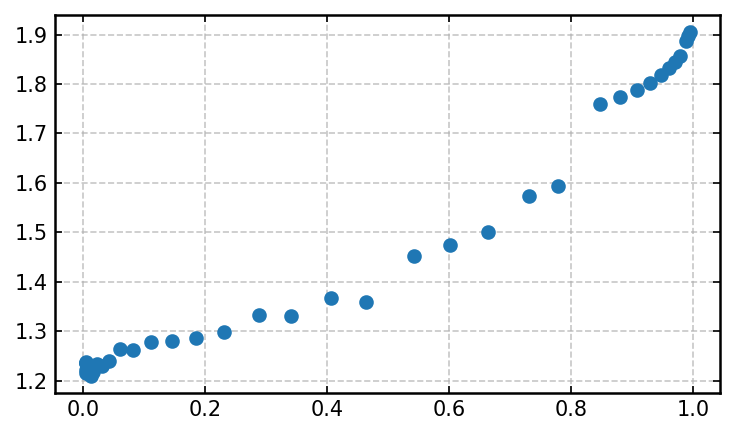

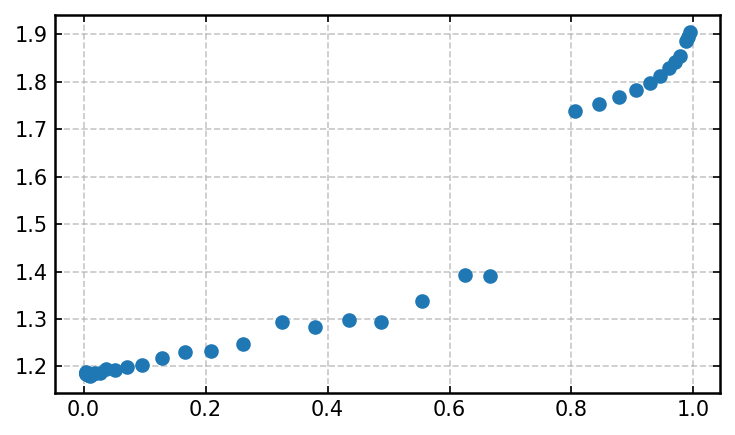

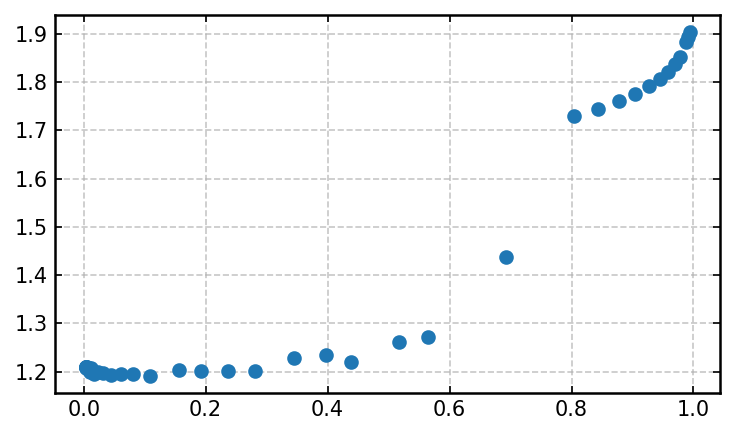

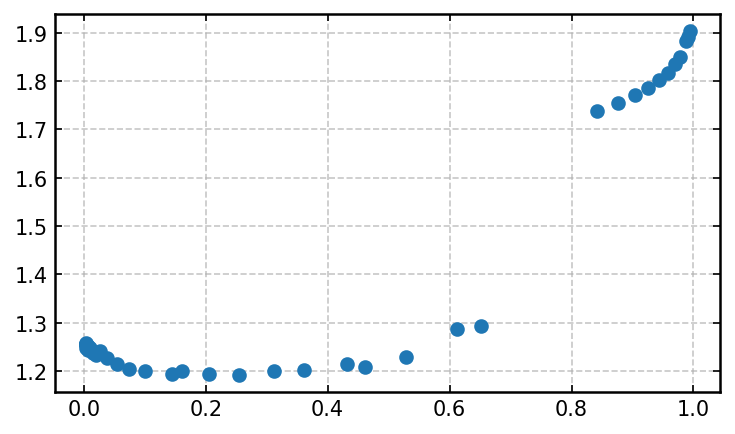

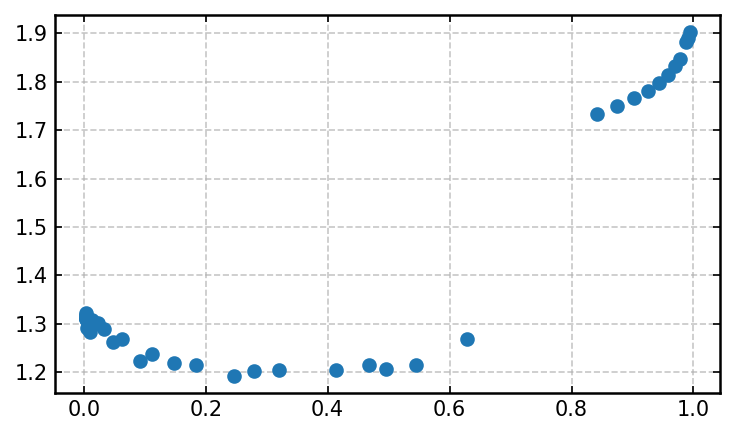

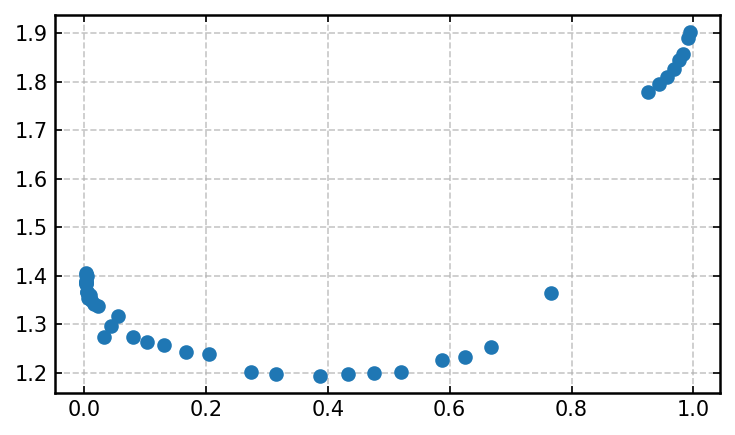

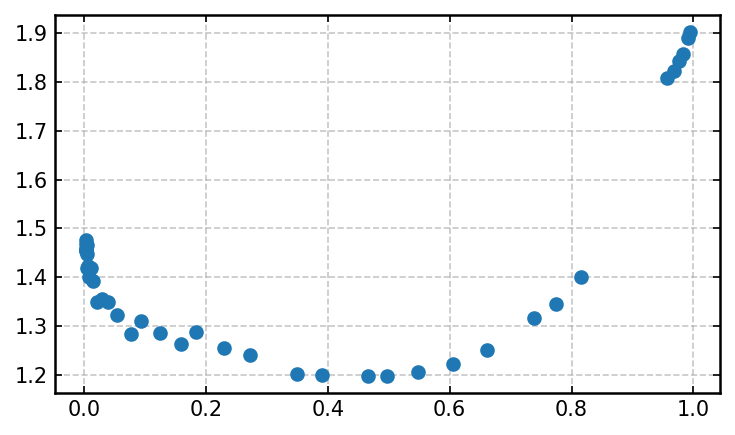

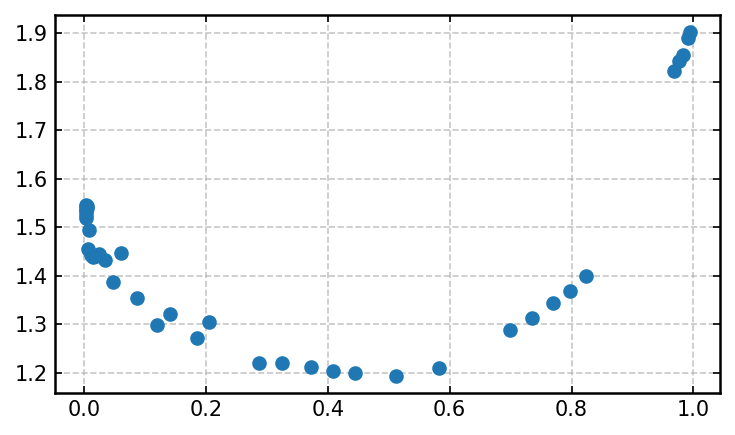

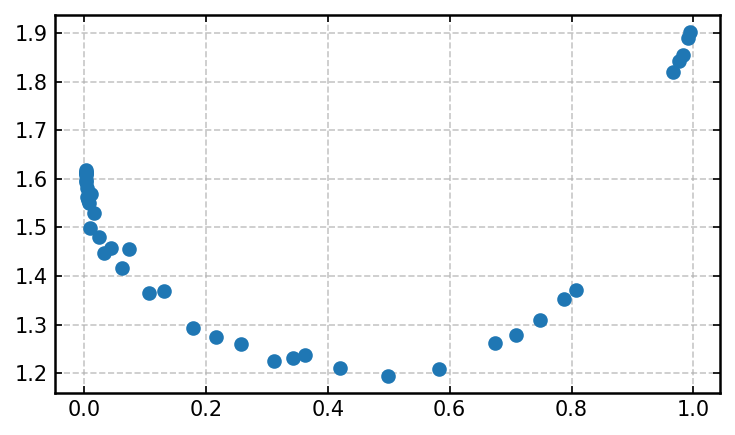

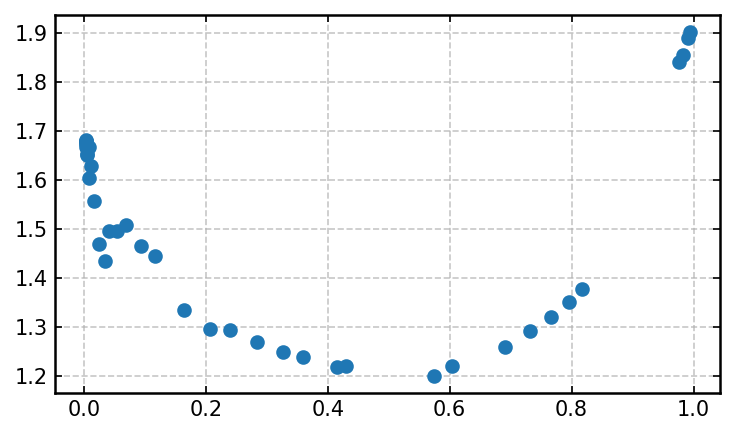

In [2]:
# cross validation with SAXS for CS+PRE reweighting

protein = 'ACTR_REST2_300K_ensemble'
rew_dir = 'rest2_rew_cs_pre/'
tauc_values = np.arange(1.0, 11.0, 1.0)

frames = np.loadtxt(data_path+rew_dir+f"PREframes.txt").astype(int)
traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load SAXS data
for i in range(len(traj_names)):
    if i==0:
        q, I_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
    else:
        q, tmpI_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
        I_gen= np.concatenate((I_gen, tmpI_gen), axis=0)

I_gen = I_gen[frames]
# experimental data
SAXS = np.loadtxt(data_path+f'./exp_data_ACTR/SAXS_bift_318K.dat')

for tc in tauc_values:
    # load reweighting data
    wopt_array = np.load(data_path+rew_dir+f"rew_wopt_array{tc}ns.npy")
    neffs = np.loadtxt(data_path+rew_dir+f"rew_neffs{tc}ns.txt")
    relESS = []
    SAXS_chi2 = []
    for W in wopt_array:
        avg_I_gen = np.average(I_gen, axis=0, weights=W)
        chi2r, scaled = fit_SAXS(avg_I_gen, SAXS[:,1], SAXS[:,2])
        SAXS_chi2.append(chi2r)
        relESS.append((np.sum(W)**2/np.sum(W**2))/W.shape[0])


    # save data
    np.savetxt(data_path+rew_dir+f"SAXS_chi2r_{tc}ns.txt", SAXS_chi2)

    # plot
    plt.figure(figsize = (5, 3))



    plt.plot(neffs, SAXS_chi2, 'o')

    plt.tight_layout()
    plt.show()

